In [1]:
import sys

In [2]:
sys.path.append("../")

In [34]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from helpers import read_configuration_file
from train import main
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType

In [5]:
# let's plot the clusters and see what we have
def plot_cluster(filename, nbins=35, kde=False, rug=True):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        cluster_0_counts = [float(item) for item in arraystr]
        sns.distplot(cluster_0_counts, bins=nbins, kde=kde, rug=rug)
        plt.show()

In [6]:
def print_hmm_info(hmm_file):
    with open(hmm_file) as json_file:
        hmm_json_map = json.load(json_file)
        hmm_json_map = json.loads(hmm_json_map)
        
        print("Start state: ")
        print("Distribution: ", hmm_json_map["start"]["distribution"])
        print("End state:")
        print("Distribution: ", hmm_json_map["end"]["distribution"])

        states = hmm_json_map["states"]
    
        for state in states:
            print("====================================================")
            print("State: ", state["name"])
            print("State weight: ", state["weight"])
            distribution = state["distribution"]

            if distribution is not None:

                print("Distribution: ", distribution["class"])

                if distribution["class"] == "Distribution":
                    print("Distribution name: ", distribution["name"])

                    if distribution["name"] == "IndependentComponentsDistribution":
                        distributions = distribution["parameters"][0]
                        for dist in distributions:

                            if dist["class"] == "GeneralMixtureModel":
                                gmm_distributions = dist["distributions"]

                                for gmm_dist in gmm_distributions:
                                    print("Distribution name: ", gmm_dist["name"])
                                    print("Distribution params: ", gmm_dist["parameters"])
                                print("Weights: ", dist["weights"])
                            else:
                                print("Distribution name: ", dist["name"])
                                print("Distribution params: ", dist["parameters"])
                                print("Weights: ", distribution["parameters"][1])
                elif distribution["class"] == "GeneralMixtureModel":
                    distributions = distribution["distributions"]

                    for dist in distributions:
                        print("Distribution name: ", dist["name"])
                        print("Distribution params: ", dist["parameters"])
                    print("Weights: ", distribution["weights"])

In [7]:
sns.set(color_codes=True)

In [8]:
ffile = "../../"
cluster_files=[(ffile +  "cluster_0_wga_w_mean.txt", ffile +  "cluster_0_no_wga_w_mean.txt"),
               (ffile +  "cluster_1_wga_w_mean.txt", ffile +  "cluster_1_no_wga_w_mean.txt"),]
               #(ffile +  "cluster_2_wga_w_mean.txt", ffile +  "cluster_2_no_wga_w_mean.txt")]

Cluster:  0


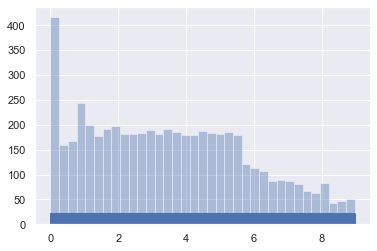

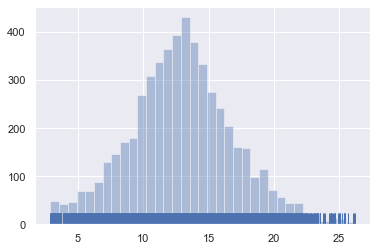

Cluster:  1


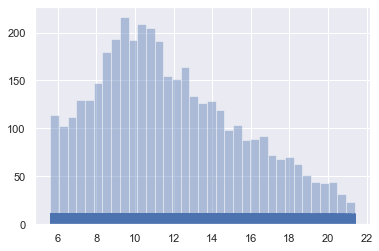

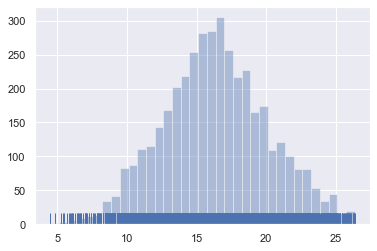

In [9]:
for i, files in enumerate(cluster_files):
    print("Cluster: ", i)
    plot_cluster(filename=files[0])
    plot_cluster(filename=files[1])

In [31]:
# load the configuration
configuration=read_configuration_file("../config.json")

In [11]:
# set up the configuration for the HMM training
clusters_config = configuration["clusters"]

In [12]:
print(clusters_config)

{'normal': {'filename': '/home/a/ag568/cluster_0.txt', 'state': 'normal', 'distributions': {'type': 'distribution', 'name': 'normal'}}, 'tuf': {'filename': '/home/a/ag568/cluster_1.txt', 'state': 'tuf', 'distributions': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}}}


In [13]:
# which cluster is normal
normal_state_cluster = clusters_config['normal']


In [26]:
# set the filename and the distribution
normal_state_cluster['filename']="/home/a/ag568/cluster_0.txt"
normal_state_cluster['state']="normal"
normal_state_cluster['distributions']['type'] = 'distribution'
normal_state_cluster['distributions']['name'] = 'normal'


In [23]:
# which cluster is TUF?
tuf_state_cluster = clusters_config['tuf']

In [24]:
# set the filename and the distribution
tuf_state_cluster['filename']="/home/a/ag568/cluster_1.txt"
tuf_state_cluster['state']="tuf"
tuf_state_cluster['distributions']['type'] = 'gmm'
tuf_state_cluster['distributions']['uniform']['params'] = [2.0, 8.0]

In [17]:
# add one more cluster
extra_cluster = {'filename': '/home/a/ag568/cluster_0.txt', 'state': 'delete',
                'distributions':{'type':'distribution', 'name': 'poisson'}}



In [18]:
clusters_config['delete'] = extra_cluster


In [18]:
print(clusters_config)


{'normal': {'filename': 'cluster_0.txt', 'state': 'normal', 'distributions': {'type': 'distribution', 'name': 'normal'}}, 'tuf': {'filename': 'cluster_1.txt', 'state': 'tuf', 'distributions': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}}}


In [19]:
hmm_states = configuration["HMM"]["states"]

In [20]:
print(hmm_states)

{'tuf': {'name': 'tuf', 'start_prob': 0.48}, 'normal': {'name': 'normal', 'start_prob': 0.48}, 'gap_state': {'name': 'gap_state', 'start_prob': 0.04}}


In [22]:
hmm_states['delete'] = { "name":"delete", "start_prob":0.04}

In [23]:
print(hmm_states)

{'tuf': {'name': 'tuf', 'start_prob': 0.48}, 'normal': {'name': 'normal', 'start_prob': 0.48}, 'gap_state': {'name': 'gap_state', 'start_prob': 0.04}, 'delete': {'name': 'delete', 'start_prob': 0.04}}


In [24]:
# we also need to add the extra transition
hmm_transitions =  configuration["HMM"]["transitions"]

In [25]:

print(hmm_transitions)

{'tuf-tuf': 0.95, 'normal-normal': 0.95, 'tuf-normal': 0.05, 'normal-tuf': 0.05, 'gap_state-gap_state': 0.95, 'gap_state-tuf': 0.05, 'tuf-gap_state': 0.05, 'normal-gap_state': 0.05, 'gap_state-normal': 0.05}


In [26]:
hmm_transitions["delete-delete"] = 0.95
hmm_transitions["delete-normal"] = 0.05
hmm_transitions["normal-delete"] = 0.05
hmm_transitions["tuf-delete"] = 0.05
hmm_transitions["delete-tuf"] = 0.05
hmm_transitions["gap_state-delete"] = 0.05
hmm_transitions["delete-gap_state"] = 0.05


In [27]:
print(hmm_transitions)

{'tuf-tuf': 0.95, 'normal-normal': 0.95, 'tuf-normal': 0.05, 'normal-tuf': 0.05, 'gap_state-gap_state': 0.95, 'gap_state-tuf': 0.05, 'tuf-gap_state': 0.05, 'normal-gap_state': 0.05, 'gap_state-normal': 0.05, 'delete-delete': 0.95, 'delete-normal': 0.05, 'normal-delete': 0.05, 'tuf-delete': 0.05, 'delete-tuf': 0.05, 'gap_state-delete': 0.05, 'delete-gap_state': 0.05}


In [32]:
# now we can train
main(configuration=configuration)

INFO: Set up logger
INFO: Done...
INFO: Load regions...
INFO: Check window sanity for region 0
INFO: Done...
INFO: Done. Execution time 10.383314792008605 secs
INFO: Load clusters
INFO: Done. Execution time 0.002675408002687618 secs
INFO: Build cluster densities
INFO: Done. Execution time 0.00028091701096855104 secs
INFO: Star HMM initialization...
INFO: State: GAP_STATE
INFO: Distributions: {'class': 'Distribution', 'name': 'IndependentComponentsDistribution', 'parameters': [[{'class': 'Distribution', 'name': 'UniformDistribution', 'parameters': [-999.5, -998.5], 'frozen': False}, {'class': 'Distribution', 'name': 'UniformDistribution', 'parameters': [-999.5, -998.5], 'frozen': False}], [1.0, 1.0]], 'frozen': False}
INFO: State: normal
INFO: Distributions: {'class': 'Distribution', 'name': 'IndependentComponentsDistribution', 'parameters': [[{'class': 'Distribution', 'name': 'NormalDistribution', 'parameters': [3.4931454172111254, 2.3440296310581696], 'frozen': False}, {'class': 'Dist

In [35]:
# load the hmm
try:
    hmm_file = "/home/a/ag568/HMM_Model_0.json"
    print_hmm_info(hmm_file=hmm_file)
except FileNotFoundError as e:
    hmm_file = "HMM_Model_0.json"
    print_hmm_info(hmm_file=hmm_file)
    

Start state: 
Distribution:  None
End state:
Distribution:  None
State:  GAP_STATE
State weight:  1.0
Distribution:  Distribution
Distribution name:  IndependentComponentsDistribution
Distribution name:  UniformDistribution
Distribution params:  [-999.5, -998.5]
Weights:  [1.0, 1.0]
Distribution name:  UniformDistribution
Distribution params:  [-999.5, -998.5]
Weights:  [1.0, 1.0]
State:  normal
State weight:  1.0
Distribution:  Distribution
Distribution name:  IndependentComponentsDistribution
Distribution name:  NormalDistribution
Distribution params:  [3.400174094268672, 2.3616453740025616]
Weights:  [1.0, 1.0]
Distribution name:  NormalDistribution
Distribution params:  [13.075396516275388, 3.3259757396581024]
Weights:  [1.0, 1.0]
State:  tuf
State weight:  1.0
Distribution:  Distribution
Distribution name:  IndependentComponentsDistribution
Distribution name:  NormalDistribution
Distribution params:  [12.271627151002086, 5.079541871874996]
Distribution name:  UniformDistribution
D

In [37]:
# this is the model we trained
hmm = build_hmm(hmm_file)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


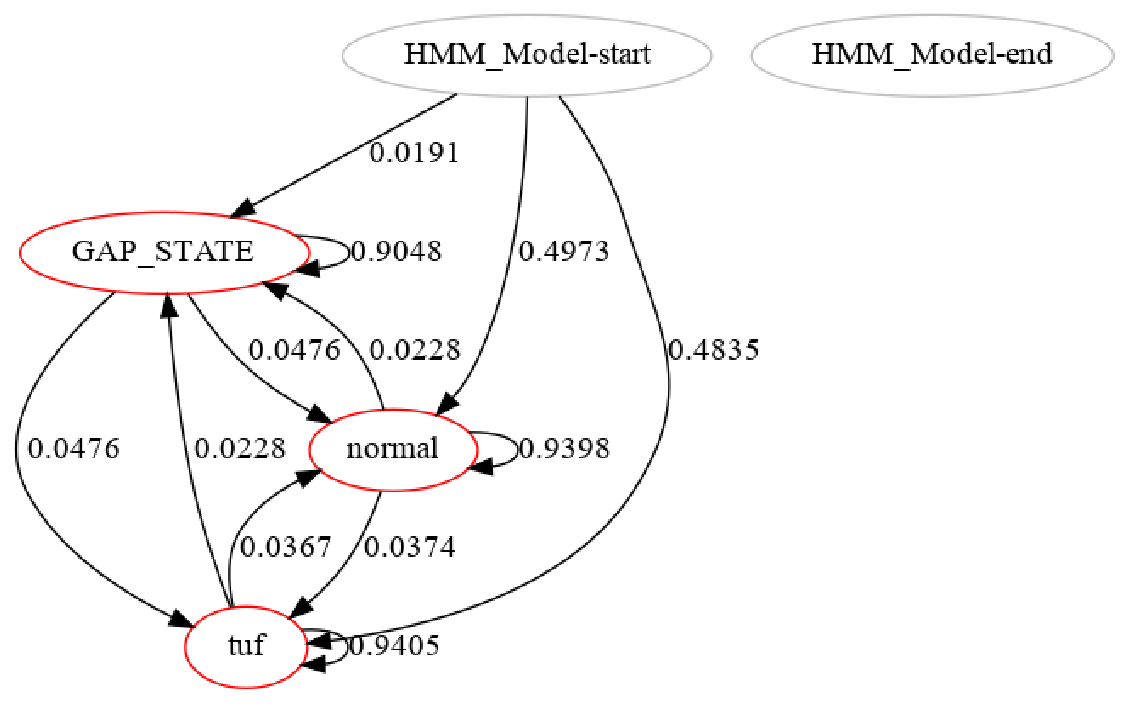

In [38]:
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm.plot()
plt.show()

if we don't want to allow updates to the model, comment this out

In [39]:

hmm.freeze()


The regions are stored in the ```regions_files``` entry. We can edit this list and add/subtrat accordingly.
Here we load all the regions used in fitting the HMM.

In [40]:
regions = load_regions(configuration=configuration)

INFO: Load regions...
INFO: Check window sanity for region 0
INFO: Done...
INFO: Done. Execution time 10.347232487998554 secs


In [41]:
print("Number or regions: {0}".format(len(regions)))

Number or regions: 1


Construct sequences of size ```size``` from the first region. The ```window_type``` indicates which of the two samples to use. Valid options are ```WindowType.WGA```, ```WindowType.NO_WGA``` and ```WindowType.BOTH```.
```n_seqs``` indicates how many sequences to extract. If set to ```None``` the whole region is partitioned into sequences with size ```size```.  

In [42]:
n_seqs=10
sequences = regions[0].get_region_as_sequences(size=100, window_type=WindowType.BOTH, n_seqs=n_seqs)

For each of the sequences, run the Viterbi algorithm on the sequence given the model. This finds the ML path of hidden states given the sequence. Returns a tuple of the log probability of the ML path, or (-inf, None) if the sequence is impossible under the model. 
If a path is returned, it is a list of tuples of the form (sequence index, state object).

In [47]:
for seq in sequences:
    
    print("Sequence size: ", len(seq))
    viterbi_path = hmm.viterbi(seq)
    
    print("Log-probability of ML Viterbi path: ", viterbi_path[0])

    if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))

        for item in range(len(seq)):
            print("sequnce item: {0} state {1}".format(seq[item], viterbi_path[1][item+1][1].name))

Sequence size:  100
Log-probability of ML Viterbi path:  -550.5821809959716
Viterbi path length:  101
sequnce item: (5.44, 5.35) state normal
sequnce item: (3.42, 7.35) state normal
sequnce item: (6.56, 8.82) state normal
sequnce item: (2.91, 10.73) state normal
sequnce item: (4.45, 19.26) state normal
sequnce item: (4.27, 10.31) state normal
sequnce item: (3.66, 12.84) state normal
sequnce item: (7.46, 14.77) state normal
sequnce item: (5.3, 13.72) state normal
sequnce item: (5.27, 13.44) state normal
sequnce item: (6.34, 17.85) state normal
sequnce item: (2.96, 13.49) state normal
sequnce item: (4.01, 14.47) state normal
sequnce item: (3.63, 11.73) state normal
sequnce item: (3.36, 11.01) state normal
sequnce item: (3.52, 13.64) state normal
sequnce item: (6.98, 6.41) state normal
sequnce item: (7.12, 11.44) state normal
sequnce item: (8.78, 11.82) state normal
sequnce item: (6.7, 10.78) state normal
sequnce item: (7.44, 12.58) state normal
sequnce item: (10.06, 15.79) state tuf
sequ

Calculate the probability of a given sequence coming from the model we trained. This uses the forward algorithm internally

In [48]:
p_d_given_m = hmm.log_probability(sequence=sequences[0])
print("P(D|M): ", p_d_given_m)

P(D|M):  -545.5943274534425


The raw normalized probability matrices can be called using

In [ ]:
hmm.predict_proba(sequences[0])